# Anomaly Detection

An autoencoder is a type of neural network that learns to reconstruct its input, making it useful for anomaly detection in signals. If a given input contains an unusual pattern that the network hasn't learned well, the reconstruction error will be high for that part, identifying the anomaly. 

In this example, we will train an autoencoder to model a known periodic signal, which can flag anomalies via a large reconstruction error. We will use a Moku device to capture the signal data, then train a neural network model that can later be deployed on the Moku for real-time anomaly detection. 

## 1. Prepare the environment

Optional: if running on a fresh environment like Google Colab, install or upgrade the Moku API library (with Neural Network support) before proceeding.

In [1]:
# Uncomment and run this if Moku library is not installed
# !pip install -U "moku[neuralnetwork]"

First, we import the necessary Python libraries.

In [2]:
import csv
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Next, we import the Moku instrument classes we need, as well as the neural network model utilities.

In [3]:
from moku.instruments import MultiInstrument, Oscilloscope, WaveformGenerator

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print(
        "Moku library is not installed. If running in an online notebook, install it with the pip command above."
    )
    raise

2025-11-27 13:44:20.873175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-27 13:44:20.924286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 13:44:22.171780: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


We'll define some helper functions for later use, particularly ffor formatting and data I/O.

In [31]:
def format_sampling_rate(rate):
    """Format a sampling rate in Hz to kHz or MHz if applicable."""
    if rate >= 1e6:
        return f"{rate / 1e6:.2f} MHz"
    elif rate >= 1e3:
        return f"{rate / 1e3:.2f} kHz"
    else:
        return f"{rate:.2f} Hz"


def save_data_to_csv(data_points, window_size, filename):
    """Save 1D data points into CSV file, splitting into fixed-size windows per row."""
    # Ensure all values are floats
    data_points = [float(x) for x in data_points]

    # Split data into consecutive windows of length window_size
    windows = []
    num_points = len(data_points)
    i = 0
    while i + window_size <= num_points:
        windows.append(data_points[i : i + window_size])
        i += window_size
    # Handle the last partial window (pad or adjust start to full length)
    if i < num_points:
        start = max(0, num_points - window_size)
        windows.append(data_points[start:num_points])

    # Determine next ID for data frames by counting existing rows in file
    file_exists = os.path.exists(filename)
    next_id = 0
    if file_exists:
        with open(filename, 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader, None)  # skip header
            next_id = sum(1 for _ in reader)

    # Append new data windows to the CSV
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['id', 'data'])  # write header if new file
        for w in windows:
            writer.writerow([next_id, ';'.join(f"{x:.6f}" for x in w)])
            next_id += 1


def load_data_from_csv(filename):
    """Load data windows from the CSV file back into a list of lists of float values."""
    data_windows = []
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # skip header if present
        for row in reader:
            if len(row) < 2:
                continue  # skip malformed rows
            # Each row's second column is a ';'-separated list of values
            values = [float(x) for x in row[1].split(';')]
            data_windows.append(values)
    return data_windows

We also define a function for inserting artifical anomalies for testing our model's performance. This function is only for model testing purposes and is intended to simulate an anomaly occurence in a dataset. If you wish to train the model on anomalous datasets, you may make appropriate changes to the gathered data in a later section with this function as well. 

In [ ]:
def insert_artificial_anomaly(y, anomaly_type="noise", anomaly_size=1.0):
    """
    Insert an artificial anomaly into an existing time series.

    Parameters:
    - y (numpy array): input time series (e.g., sine wave)
    - anomaly_type (str): type of anomaly ('spike', 'drop', 'noise')
    - anomaly_size (float): magnitude of anomaly effect

    Returns:
    - y_anom (numpy array): time series with anomaly
    """
    y_anom = y.copy()
    samples = len(y)

    # Pick a random anomaly point
    anomaly_index = np.random.randint(0, samples)

    # Insert anomaly
    if anomaly_type == "spike":
        y_anom[anomaly_index] += anomaly_size
    elif anomaly_type == "drop":
        y_anom[anomaly_index] -= anomaly_size
    elif anomaly_type == "noise":
        # Add random noise around anomaly_index
        noise = np.random.normal(0, anomaly_size, size=5)
        start = max(0, anomaly_index-2)
        end = min(samples, anomaly_index+3)
        y_anom[start:end] += noise[:end-start]
    else:
        raise ValueError("anomaly_type must be 'spike', 'drop', or 'noise'")

    return y_anom

We can see the available Moku devices, using the Moku CLI through the command line as a quick check.

In [ ]:
! mokucli list

The above command should output a list of connected Moku devices with their name, serial, IP, etc. Ensure your Moku device is listed and reachable.

## 2. Set up the Oscilloscope for data collection

First, set up the folder structure for organizing output data and define the filename for captured data frames

In [6]:
# Define output folder and base filename
output_folder = "AD_dataset/"
output_filename = "AD_data_training"

# Generate a unique filename with timestamp to avoid overwriting
timestamp = str(time.time()).split(".")[-1]
output_filename = f"{output_folder}{output_filename}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename}")


# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")

Data will be saved in the file: AD_dataset/AD_data_training_022433.csv
Folder already exists: AD_dataset/


Now, deploy the Oscilloscope instrument on your Moku. Connect to your Moku hardware by initializing a MultiInstrument with the device's IP address. In this example we use a Moku:Pro, and so we set platform_id to 4. 

Connections in Multi-Instrument Mode are defined by an array of dictionaries. In this example, we will generate our own sin signal using a waveform generator instrument. 

Learn more about the instrument here. 
https://apis.liquidinstruments.com/api/reference/waveformgenerator/

We also define the coupling, attenuation, and impedance of the frontend.

Note: Replace '10.1.xxx.xxx' with your Moku’s IP address (and adjust platform_id if using a different Moku model).

In [7]:
# Connect to the Moku device and deploy an Oscilloscope instrument
mim = MultiInstrument('10.1.xxx.xxx', force_connect=True, platform_id=4)
waveGen = mim.set_instrument(1, WaveformGenerator)
waveGen.generate_waveform(channel=1, type='Sine', amplitude=1, frequency=1e2)

osc = mim.set_instrument(2, Oscilloscope)

connections = [dict(source="Input1", destination="Slot1InA"),
               dict(source="Slot1OutA", destination="Slot2InA"),
               dict(source="Slot2OutA", destination="Output1")]
mim.set_connections(connections=connections)
mim.set_frontend(channel=1, impedance="50Ohm", coupling="DC", attenuation="20dB")

{'attenuation': '20dB', 'coupling': 'DC', 'impedance': '50Ohm'}

Configure the Oscilloscope acquisition parameters, including number of samples and how many frames of data to capture, as well as the waveform generator to produce the wave we desire.

In [8]:
# Acquisition parameters
window_size = 100  # number of samples per frame (window length)
n_frames = 100  # number of frames to capture for dataset
t1 = 0.0  # start time (seconds)
t2 = 0.1  # end time (seconds) for each frame
duration = t2 - t1

# Set the oscilloscope timebase for each frame capture
osc.set_timebase(t1, t2)

{'t1': 0.0, 't2': 0.1}

Now collect the data frames from the Oscilloscope via the get_data command. We will capture n_frames frames of channel data and save them to the CSV file defined above. The code below reads data from the Oscilloscope, uses our save_data_to_csv function to append each frame to the file, and prints progress as it goes.

In [9]:
for i in tqdm(range(n_frames), desc="Saving data"):
    data = osc.get_data()
    save_data_to_csv(data["ch1"], window_size, filename=output_filename)

Saving data:   0%|          | 0/100 [00:00<?, ?it/s]

Now let's verify the sampling rate and examine one captured frame of data as an example

Sampling rate: 143.02 kHz


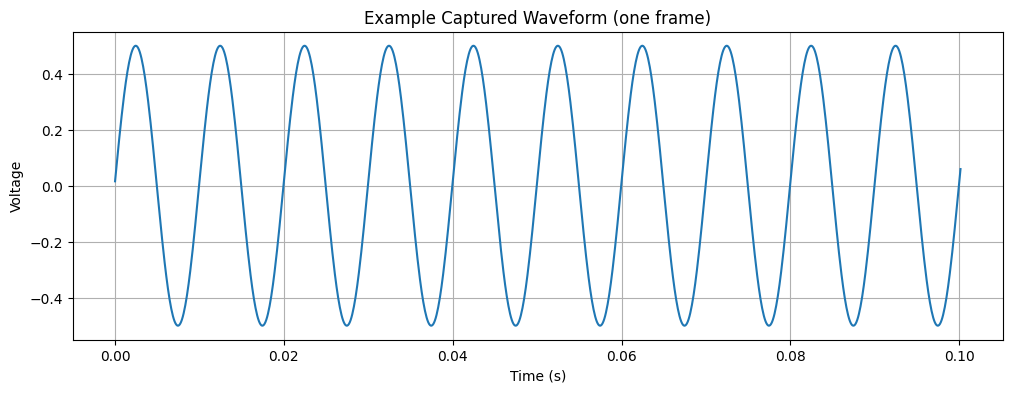

In [10]:
# Compute and display the sampling rate based on captured data
sampling_rate = osc.get_samplerate()
print("Sampling rate:", format_sampling_rate(osc.get_samplerate()["sample_rate"]))

# Plot an example frame of the captured data
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["ch1"])
plt.title("Example Captured Waveform (one frame)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()

Print the first 100 datapoints of the frame. This 100-datapolint signal is an example of the training data that will be used for training the autoencoder.

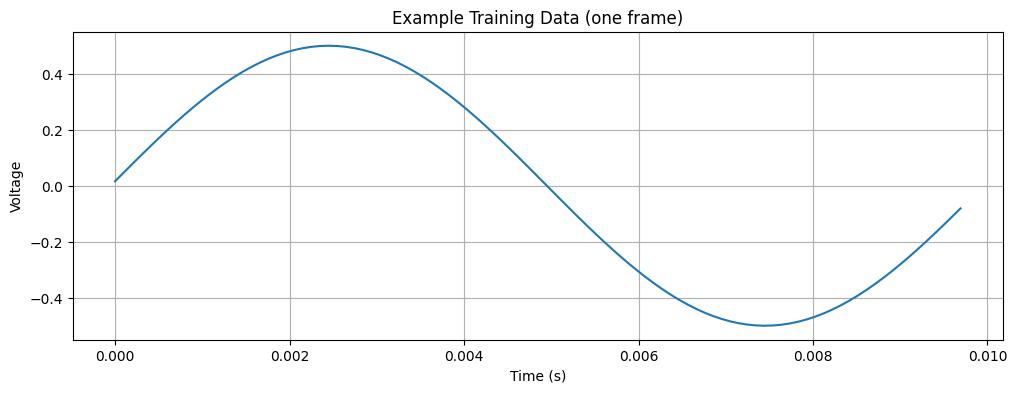

In [11]:
# Plot an example frame of the training data
plt.figure(figsize=(12, 4))
plt.plot(data["time"][:100], data["ch1"][:100])
plt.title("Example Training Data (one frame)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()

## 3. Compose the training dataset

Now that data has been collected, we load it from the CSV and split it into separate training and testing sets. We will use a simple 80/20 split.

In [12]:
# Read the saved frames from CSV
data = load_data_from_csv(output_filename)

# Split into training and testing datasets (80% train, 20% test)
split_index = int(len(data) * 0.8)
full_training_dataset = data[:split_index]
full_testing_dataset = data[split_index:]

print(f"N. of frames in the training dataset: {len(full_training_dataset)}")
print(f"N. of frames in the testing dataset: {len(full_testing_dataset)}")

N. of frames in the training dataset: 880
N. of frames in the testing dataset: 220


## 4. Define the model and train

Instantiate the Moku Neural Network model object using LinnModel.

In [13]:
quant_mod = LinnModel()

Set up an early stopping point for training to avoid overfitting. This will truncate the training if the validation loss doesn’t improve for 10 epochs.

In [14]:
early_stopping_config = {
    'patience': 10,  # allow 10 epochs without improvement
    'restore_best_weights': True,
    'monitor': "val_loss",
}

Now, prepare the model definition. This is an autoencoder, a small fully-connected neural network that compresses and then reconstructs the input signal. The model will output the same number of samples as the input frame (100). We disable automatic scaling of data (scale=False) because we want to work with raw values.

In [15]:
frame_length = len(full_training_dataset[0])
print(f"frame length/input dimension: {frame_length}")

# Configure the model inputs/outputs (autoencoder: outputs = inputs)
quant_mod.set_training_data(
    training_inputs=full_training_dataset, training_outputs=full_training_dataset, scale=False
)

# Define a simple autoencoder architecture:
#  - encoder layers with 64, 32, 16 neurons (tanh activations)
#  - final decoder layer with 'frame_length' neurons (linear activation)
model_definition = [(64, 'tanh'), (32, 'tanh'), (16, 'tanh'), (frame_length, 'linear')]

# Build the model
quant_mod.construct_model(model_definition)

frame length/input dimension: 100


2025-11-27 13:44:56.300386: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Now train the model on the training dataset we defined earlier. We include a 10% validation split (which comes from the training set itself) for early stopping.

In [16]:
history = quant_mod.fit_model(
    epochs=250, es_config=early_stopping_config, validation_split=0.1, verbose=1
)

Value for restore missing. Using default:False.


Epoch 1/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1026 - val_loss: 0.0673
Epoch 2/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - val_loss: 0.0217
Epoch 3/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0097
Epoch 4/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 5/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 7/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3924e-04 - val_loss: 4.8894e-04
Epoch 8/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5998e-04 - val_loss: 2.4905e-04
Epoch 9/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9348e-04 - val_loss: 1.4429e-04
Epoch 10/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1824e-04 - val_loss: 9.4588e-05
Epoch 11/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1903e-05 - val_loss: 6.9058e-05
Epoch 12/250
25/25 ━━━━

Plot the training and validation loss history to confirm convergence

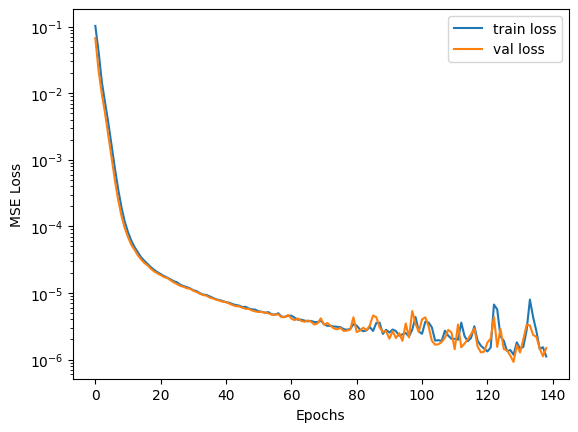

In [17]:
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

In this case, the final loss values are extremely low, indicating the autoencoder learned to reconstruct our sine wave signals very accurately. Next, save the quantized model to a file using save_linn. This will produce a .linn file that can be deployed to the Moku device’s FPGA for real-time inference.

In [18]:
model_filename = "AD_model.linn"
# Create a time-base array for mapping (same length as frame)
T = np.linspace(-1, 1, frame_length)
# Save the trained model to file
save_linn(
    quant_mod,
    input_channels=1,
    output_channels=1,
    file_name=model_filename,
    output_mapping=[T.size - 1],
)

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


## 5. Testing the model - reconstruct the training dataset
Now that the model is trained, let’s verify how well it performs on data it saw during training. We feed the entire training dataset through the model to get reconstructed signals.

In [19]:
full_training_dataset_np = np.array(full_training_dataset)
reconstructions = quant_mod.predict(full_training_dataset_np, scale=False, unscale_output=False)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


The reconstructions array contains the model output for each input frame. For a well-trained autoencoder, these reconstructed frames should closely match the originals. As a quick visual check, we can pick one training frame and compare it with its reconstruction

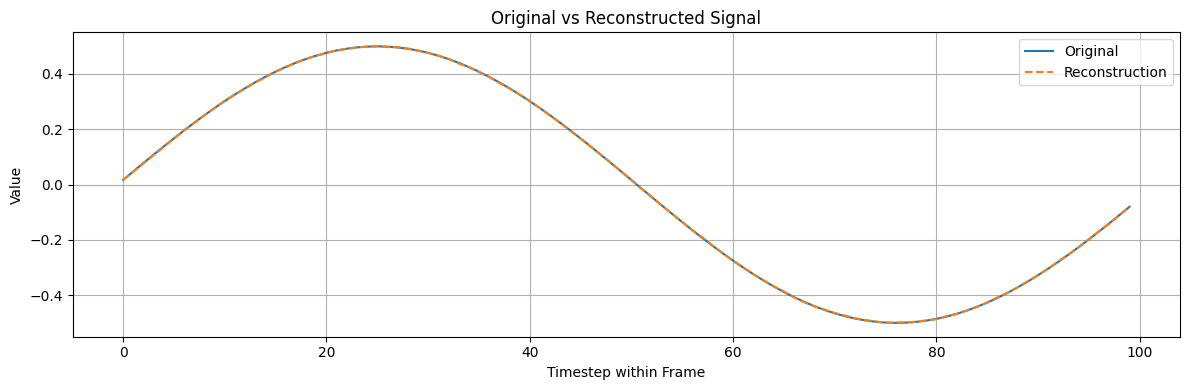

In [20]:
frame_id = 0  # for example, take the first training frame
plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id], label='Original')
plt.plot(reconstructions[frame_id], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Timestep within Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Testing the model on the unseen dataset
Now we evaluate the autoencoder on the frames the model has not seen before. We expect the model to reconstruct normal frames well, but frames with anomalies (such as glitches) should yield a larger reconstruction error since the model was not trained on that behavior. 

First, we pick the frames we want to examine.

In [21]:
frame_id_anomaly_test = 31
frame_id_normal_test = 146

Now we take the original testing dataset, and insert an anomaly into our chosen frame.

In [22]:
full_testing_dataset_np = np.array(full_testing_dataset)
full_testing_dataset_np[frame_id_anomaly_test] = insert_anomaly(full_testing_dataset_np[frame_id_anomaly_test])

Run the model to reconstruct.

In [23]:
reconstructions_test = quant_mod.predict(full_testing_dataset_np)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


To illustrate the model’s performance, let's compare the output on a specific test frame that contains a known anomaly versus a test frame that is normal.

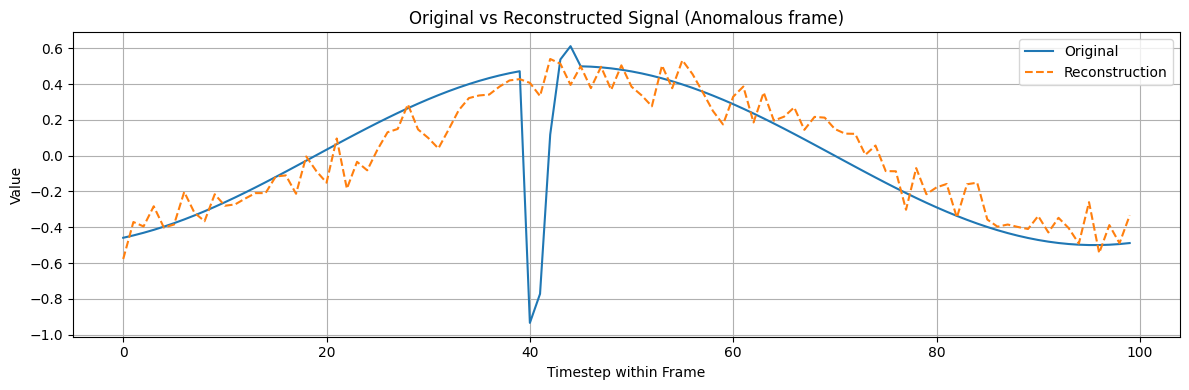

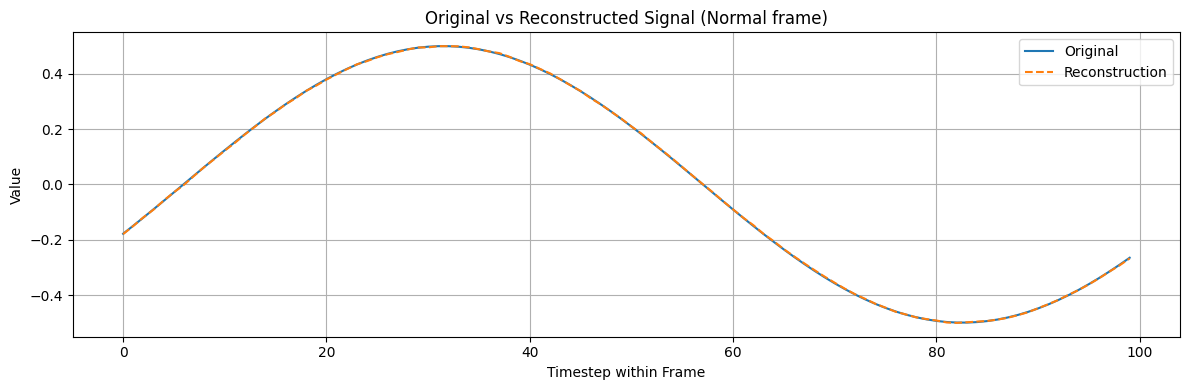

In [24]:
# Plot original vs reconstructed for the anomalous frame
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset_np[frame_id_anomaly_test], label='Original')
plt.plot(reconstructions_test[frame_id_anomaly_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal (Anomalous frame)')
plt.xlabel('Timestep within Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot original vs reconstructed for a normal frame
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset_np[frame_id_normal_test], label='Original')
plt.plot(reconstructions_test[frame_id_normal_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal (Normal frame)')
plt.xlabel('Timestep within Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

To detect the anomaly quantitatively, we need to examine the reconstruction error.

## 7. Extract the reconstruction error
Calculate the element-wise error between original and reconstructed signals for the test set.

In [25]:
original = np.array(full_testing_dataset_np)
reconstructed = np.array(reconstructions_test)

# --- Error calculations ---
# Absolute error for each sample
absolute_error = np.abs(original - reconstructed)
# Squared error for each sample
squared_error = (original - reconstructed) ** 2

# Summed error per frame (could be used as an anomaly score per frame)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)

Now, compare the error profiles of the previously chosen anomalous frame with the normal frame. We expect the frame with the glitch to show a spike in error at the glitch location, whereas the normal frame’s error should remain near zero across all sample indices. For example, we can plot the squared error for both frames on the same graph.

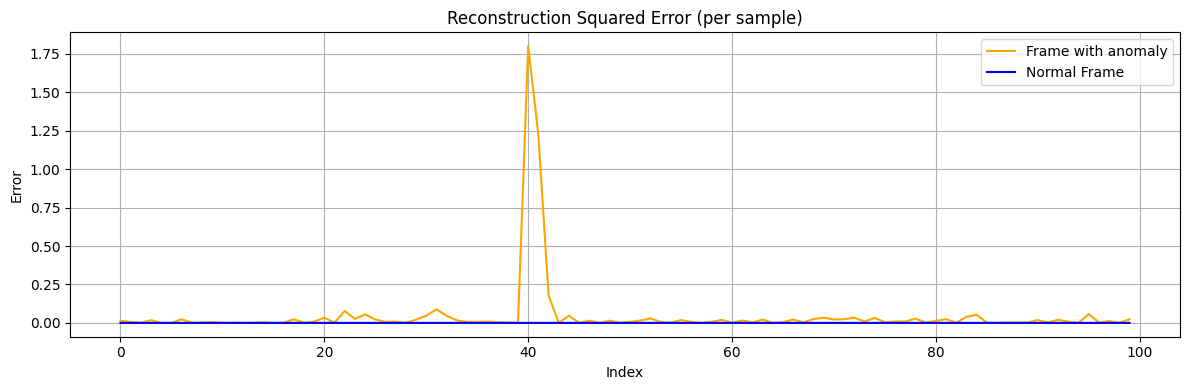

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(squared_error[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal_test], label='Normal Frame', color='blue')
plt.title('Reconstruction Squared Error (per sample)')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the plot above, the anomalous frame (orange curve) has several spikes in error, whereas the normal frame error (blue line) is essentially flat at zero. This indicates the autoencoder was unable to reconstruct those glitch points, as expected. 

We can further quantify this by applying a numerical threshold. In this example we'll set this threshold at an absolute error of 0.0002.

In [27]:
threshold = 0.0002

# Find indices in the anomaly frame where absolute error > threshold
indices_anom = [i for i, v in enumerate(squared_error[frame_id_anomaly_test]) if v > threshold]
values_anom = [squared_error[frame_id_anomaly_test][i] for i in indices_anom]
print("Frame with anomaly")
print("Indices of values > threshold:", indices_anom)
print("Corresponding values:", values_anom)

print("—" * 70)

# Find indices in the normal frame where absolute error > threshold
indices_norm = [i for i, v in enumerate(squared_error[frame_id_normal_test]) if v > threshold]
values_norm = [squared_error[frame_id_normal_test][i] for i in indices_norm]
print("Normal frame")
print("Indices of values > threshold:", indices_norm)
print("Corresponding values:", values_norm)

Frame with anomaly
Indices of values > threshold: [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99]
Corresponding values: [np.float64(0.01406841751757289), np.float64(0.005623820470090531), np.float64(0.00126237644520031), np.float64(0.017373804715392765), np.float64(0.02364359652508788), np.float64(0.0002439142337994523), np.float64(0.003083336802581871), np.float64(0.004951128612829319), np.float64(0.0003787614910547395), np.float64(0.0015098237554280107), np.float64(0.0011253185512621292), np.float64(0.0009990052276240573), np.float64(0.0036823971417963126), np.float64(0.00045402842746731543), np.float64(0.023842468120162146), np.float64(0.0005471061828056652), np.float64(0.0079767

As expected, the anomalous frame has a few samples where the reconstruction error exceeds the threshold, while the normal frame has none. These correspond to the glitch points in the signal. 

To further reduce false detections, we experimented with using higher-order error metrics. For example, defining a "focal MSE loss" (squared error raised to a power >1) can down-weight small differences and emphasize larger errors.

In [28]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error**2
    return squared_error**gamma


# Compute focal loss for each sample
focal_loss = focal_mse_loss(reconstructed, original)
focal_loss_per_frame = focal_loss.sum(axis=1)

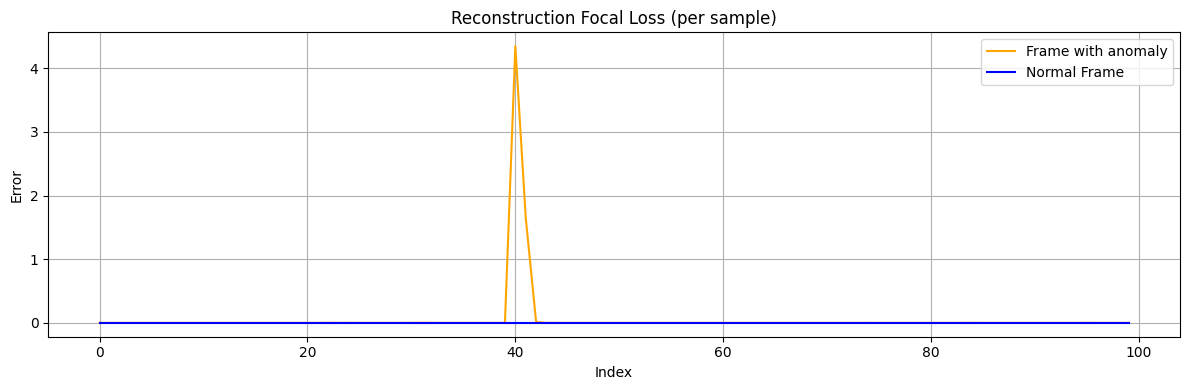

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(focal_loss[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id_normal_test], label='Normal Frame', color='blue')
plt.title('Reconstruction Focal Loss (per sample)')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
threshold = 1e-9

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [0, 1, 2, 3, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99]
Corresponding values: [np.float64(2.3475406524091094e-05), np.float64(2.3718030351920385e-06), np.float64(5.6620305198663076e-08), np.float64(3.9786646854346964e-05), np.float64(8.595751444475061e-05), np.float64(5.279009173351058e-07), np.float64(1.7248864866340818e-06), np.float64(2.791994406485177e-09), np.float64(8.857591260420734e-08), np.float64(4.24804096446332e-08), np.float64(3.154419160482626e-08), np.float64(8.228611569360347e-07), np.float64(4.392457964310997e-09), np.float64(8.777645285296289e-05), np.float64(7.001305958688553e-09), np.float64(5.682864511736062e-06), np.float6

Overall, the autoencoder approach successfully learned the normal signal behavior and flagged the anomaly via reconstruction error. In summary:
- Normal frames: Reconstructed almost perfectly, with near-zero error across all samples.
- Anomalous frame: Reconstruction deviates at the glitch points, yielding measurable error spikes.

This demonstrates how an FPGA-deployable autoencoder, trained via Moku’s Python API, can perform real-time anomaly detection on signal data. The .linn model file saved can be loaded onto the Moku device to monitor incoming signals and detect anomalies based on the model’s reconstruction error in real time.

## Deploy on Moku

To test the model and deploy the anomaly detection feature, open your Moku on Multi-Instrument Mode. 

Place and configure the instruments as shown below.

<center>
<figure>
<img src="Screenshots/AD1_Setup.png" alt="MIM" width="600">
<figcaption>Multi-Instrument Config</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/AD1_AWG.png" alt="AWG" width="600">
<figcaption>Arbitrary Wave Generator Config</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/AD1_AWG2.png" alt="AWG_Func" width="600">
<figcaption>Anomaly Function</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/AD1_PID.png" alt="PID" width="600">
<figcaption>PID Config</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/AD1_NN.png" alt="NN" width="600">
<figcaption>Loaded Neural Network Model</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/AD1_OSC.png" alt="OSC" width="600">
<figcaption>Oscilloscope with Sin Waveform Generator</figcaption>
</figure> 
</center>

From the oscilloscope output, we can see that the neural network reconstruction (red waveform) becomes unstable with the presence of anomaly spike in the original sin waveform.

To automate anomaly detection, you can measure the difference between the original and reconstructed signals on the Moku. For example, you could use a custom Moku Cloud Compile (MCC) module that outputs the squared error. This error signal will spike when the original signal deviates from the learned normal pattern, which can be detected using a threshold trigger on the Oscilloscope or Data Logger. 